# <font color='orange'>Course on ADAPTIVE COLLECTIVE SYSTEMS</font>
# <font color='orange'>2. Moran process for evolutionary dynamics</font>

# <font color="green">Cogmaster SUP, 2023-2024</font>

*Teacher: nicolas.bredeche(at)sorbonne-universite.fr*

*Last update: Oct 1st, 2024*


This notebook can be executed in [Google Colab](colab.research.google.com/) or in Jupyter Lab.


# PLEASE FILL IN THE FOLLOWING BEFORE YOU START:

* Student 1: **_JACQUIN__Valentin__22410140_**
* Student 2: **_ISTE__Jerome__71804007_**

This practical course will be evaluated. Please send your notebook to nicolas.bredeche@sorbonne-universite.fr with subject "ACS@CogSUP TP2" before next Monday midnight. I will send you an acknoledgment (if you dont receive anything after 1 week, ask me again without resending the notebook). Good luck!

---
---
---

# <font color='orange'>PREAMBULE: initialization</font>

# Moran Process simulator

The algorithm is as follows:

* Step 1. initialize a population of N individuals. There are n residents (default is n=N-1) and m mutants (default is m=1). Fitness are fixed, the mutants' fitness can be larger (default), smaller or equal to the residents' fitness.
* Step 2. an individual is chosen with a probability proportional to its fitness
* Step 3. another individual is chosen at random for replacement
* Step 4. repeat from Step 2

The important point is that one mutant can replace any another individual (mutant or resident), even if its fitness is lower.

About the implementation used for this practical course: individuals are either residents or mutants, and bear only one trait: blue (=0) for resident, red (=1) for mutant. We will assume here that the mutant's fitness is fixed to 1.1, and the resident fitness is fixed to 1.0. The mutant should have a selective advantage (e.g. on a complete graph with inifinite population).

This cell contains all the necessary functions to run a Moran process. <font color='red'>*This cell **must** be executed before anything else. Unless you modify its content, it is not required to execute it more than once per session.*</font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import animation
from IPython.display import HTML, display
from numba import njit  # Import njit from Numba
import time
from datetime import datetime
from datetime import date
from matplotlib import rc
import matplotlib as mpl

# Set up Matplotlib to display animations in the notebook
mpl.rcParams['animation.embed_limit'] = 100  # Set the limit to 100 MB or another larger value
rc('animation', html='jshtml')


G = None
ax = None
pos = None
history = None
adj_matrix = None  # Add adjacency matrix as a global variable
nb_iterations = 0
node_collection = None  # For storing the node collection
title_text = None  # For storing the title text

def init(_nb_nodes, _edges, directed=False):
    global G, adj_matrix
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    G.add_nodes_from(range(_nb_nodes))
    G.add_edges_from(_edges)
    # Create the adjacency matrix
    adj_matrix = nx.to_numpy_array(G, dtype=np.int32)

def update(num):
    global ax, pos, history, nb_iterations, node_collection, title_text
    if num != 0 and num % (nb_iterations / 10) == 0:
        print(".", end="", flush=True)
    # Update the node colors
    colors = ['blue' if t == 0 else 'red' for t in history[num]]
    node_collection.set_color(colors)
    # Update the title
    title_text.set_text(f'Moran Process - Step {num}')
    # Return the modified artists as a list
    return [node_collection, title_text]

def show(_delay_between_displayed_frames=500):
    global G, ax, history, pos, nb_iterations, node_collection, title_text
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency

    print("Rendering Moran process")
    print("__________")

    # Draw the graph once
    colors = ['red' if t == 0 else 'blue' for t in history[0]]
    nodes = list(G.nodes())
    node_collection = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    title_text = ax.set_title('Moran Process - Step 0')

    # Create the animation
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(history),
        interval=_delay_between_displayed_frames,
        blit=True,  # Enable blitting
        repeat=False
    )
    print()
    # Display the animation
    from matplotlib import rc
    rc('animation', html='jshtml')
    plt.close(fig)  # Prevents duplicate display
    display(ani)

def run_task(_nb_nodes, _edges, _nb_iterations, _types, _delay_between_displayed_frames=500, direct=False, anim=False):
    global G, ax, pos, history, nb_iterations

    start_time = time.time()

    nb_iterations = _nb_iterations
    nb_nodes = _nb_nodes  # Ensure nb_nodes is defined
    init(nb_nodes, _edges, directed=direct)

    # Initialize the population
    types = _types

    # Define fitness for each type as a NumPy array
    fitness_values = np.array([1.0, 1.1])  # Type B has higher fitness

    # Simulate the Moran process using Numba-compiled function
    history = simulate_moran_process(types, adj_matrix, fitness_values, nb_iterations)
    if anim:
        show(_delay_between_displayed_frames)

    end_time = time.time()
    elapsed_time = end_time - start_time
    if anim:
        print(f"Elapsed time: {elapsed_time:.1f} seconds")

    return history

@njit
def simulate_moran_process(types, adj_matrix, fitness_values, num_iterations, show_progress=False):
    nb_nodes = len(types)
    history = np.empty((num_iterations + 1, nb_nodes), dtype=np.int32)
    history[0] = types.copy()


    if show_progress:
        print("Running Moran process")

    for t in range(1, num_iterations + 1):
        if show_progress and t % (num_iterations // 10) == 0:
            print((t/num_iterations*100),"%")
        fitness_array = fitness_values[types]
        total_fitness = fitness_array.sum()
        reproduction_probs = fitness_array / total_fitness

        # Compute cumulative probabilities for weighted random choice
        cumulative_probs = np.cumsum(reproduction_probs)
        r = np.random.rand()
        reproducer = np.searchsorted(cumulative_probs, r)

        # Choose a neighbor to replace
        neighbors = np.where(adj_matrix[reproducer] == 1)[0]
        if neighbors.size > 0:
          # Randomly select a neighbor uniformly
          idx = np.random.randint(0, neighbors.size)
          replaced = neighbors[idx]
          # Replace the neighbor's type with the reproducer's type
          types[replaced] = types[reproducer]

        history[t] = types.copy()
        if np.count_nonzero(types) == 0 or np.count_nonzero(types) == nb_nodes:
            # detect that the states has already converged
            for i in range(t, num_iterations + 1):
                history[i] = np.copy(history[t])
            break


    return history


#### #### ####

print("\n",date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")



 2024-10-08 07:49:45 GMT
OK.


---
---
---

# <font color='orange'>PART 1: simulating Moran process</font>

- run the two cells below, make sure you understand what is happening.
- analyse the outcome of the two simulations. What do you conclude?

**Methodological hints**:

* *(1) Simulation is stochastic. Run multiple simulations with the same set of parameters to obtain reliable results.*
* *(2) absorbing state may differ. It may not be a good idea to rely on averaged values. Suggestion: a figure can show M different lines, one for each of the M runs (x-axis: iterations, y-axis: number of mutants / population size). This will reveal different regimes, in any (e.g. mutant invades vs. mutant is suppressed).*

**Technical hint**: *history returns a snapshot of the population for each iteration. Use it to create your Figures. For the figures, you may use the code from last lab work, write your own, or use a spreadsheet software. You can also run simulation multiple times and aggregate data in any way you see fit.*

In [ ]:
# Simulation of the Moran process with a random number of mutants at the start
# We run 5 simulations with a complete graph of 10 nodes
# We record the evolution of the number of mutants at each iteration

nb_nodes = 10
delay_between_displayed_frames = 500
nb_iterations = 200
y_RandomMutants = []
for run in range(0, 5):
    x = []
    edges = [(i, j) for i in range(nb_nodes) for j in range(nb_nodes) if i != j]  # undirected complete graph without self-loops
    types_1 = np.random.choice([0, 1], size=nb_nodes).astype(np.int32)  # random distribution of residents and mutants
    history = run_task(nb_nodes, edges, nb_iterations, types_1, delay_between_displayed_frames)
    for array in history:
        x.append(np.count_nonzero(array == 1))
    y_RandomMutants.append(x)

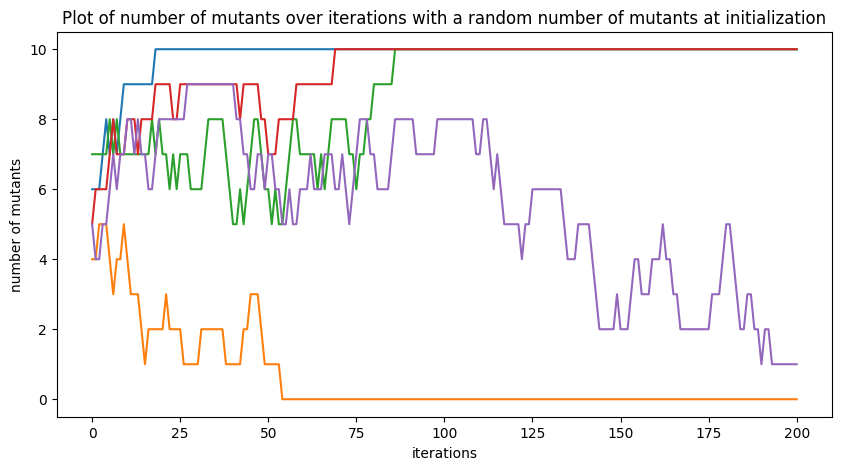

In [ ]:
# Plot the number of mutants over iterations for each simulation
import matplotlib.pyplot as plt
for essai in y_RandomMutants:
    plt.plot(essai)
plt.xlabel('iterations')
plt.ylabel('number of mutants')
plt.gcf().set_size_inches(10, 5)
plt.title('Plot of number of mutants over iterations with a random number of mutants at initialization')
plt.show()

In [ ]:
# Simulation of the Moran process with a single mutant at the start
# We run 20 simulations with a complete graph of 10 nodes
# We record the evolution of the number of mutants at each iteration

nb_iterations = 300
delay_between_displayed_frames = 50  # in ms
nb_nodes = 10
y_1mutants = []
for run in range(0, 20):
    x_1mutants = []
    edges = [(i, j) for i in range(nb_nodes) for j in range(nb_nodes) if i != j] # undirected complete graph without self-loops
    types = np.zeros(nb_nodes, dtype=np.int32) # s
    types[0] = 1 # add a single mutant
    history = run_task(nb_nodes, edges, nb_iterations, types, delay_between_displayed_frames)
    for array in history:
        x_1mutants.append(np.count_nonzero(array == 1))
    y_1mutants.append(x_1mutants)

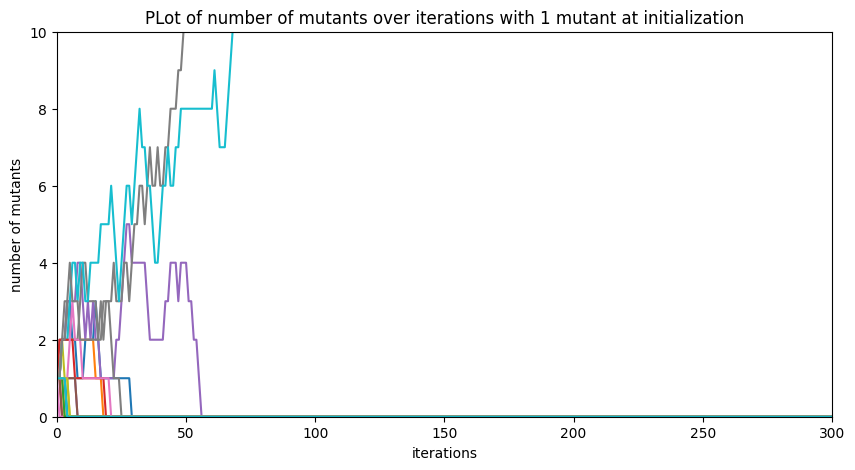

In [ ]:
# Plot the number of mutants over iterations for each simulation
import matplotlib.pyplot as plt
for t in y_1mutants:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants')
plt.ylim(0, 10)
plt.xlim(0, 300)
plt.gcf().set_size_inches(10, 5)
plt.title('PLot of number of mutants over iterations with 1 mutant at initialization')
plt.show()



These are simulations of isothermal graphs (i.e., all nodes have the same probability of being replaced).

1. **Graph 1: Evolution of the Number of Mutants (Random Initial Count)**
    - This graph shows the evolution of the number of mutants, starting with a random number of mutants.
    - Observation: As the number of initial mutants increases, the tendency of the mutants to spread also increases.

2. **Graph 2: Evolution of the Number of Mutants (Single Initial Mutant)**
    - This graph shows the evolution of the number of mutants, starting with only one mutant.
    - Observation: The mutant seems to have a high probability of disappearing in the end, even though it has a higher fitness value than the resident.

**Conclusion:**
- Even if a mutant has a better fitness than the resident, its probability of fixation seems to be linked to the number of mutants in the initial state (i.e. more mutant in the initial state implying a higher probability of fixation).

---
---
---

# <font color='orange'>PART 2: suppressor of selection</font>

Study the two suppressor graphs seen in the lecture's slides, starting with one mutant. Confirm experimentally the probability of fixation. Show a figure with multiple runs (X-axis: iterations, Y-axis: number of mutants / population size).

Explore the sensitivity to the number of nodes.

In [ ]:
# Simulation of the Moran process with a single mutant at the start
# We run 2000 simulations with a suppresor graph of 5 nodes "g"
# We record the evolution of the number of mutants at each iteration
# And we count the number of fixation events to calculate the fixation probability
from random import randint
nb_iterations = 300
delay_between_displayed_frames = 50  # in ms
l_results = []
nb_nodesSupr1 = 5
cptFix = 0
nbrRun = 2000

# Loop over the number of runs
for test in range(0, nbrRun):
    types_F = np.zeros(nb_nodesSupr1, dtype=np.int32)
    types_F[randint(0, nb_nodesSupr1 - 1)] = 1  # Fix the range to be within bounds
    history_F = run_task(nb_nodesSupr1, [(0, i) for i in range(1, nb_nodesSupr1)], nb_iterations, types_F, delay_between_displayed_frames, direct=True)
    x_F = []
    fixation = False
    # Iteration per Run
    for array in history_F:
        nb_mut = np.count_nonzero(array == 1) / nb_nodesSupr1
        if nb_mut == 1 and not fixation:
            fixation = True
            cptFix += 1
        x_F.append(nb_mut)
    l_results.append(x_F)

Fixation probability with suppressive graph 'g':  0.19


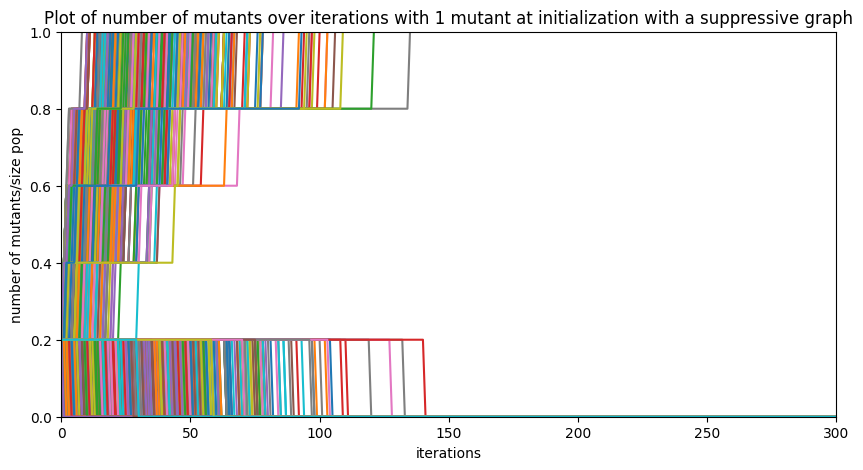

In [ ]:
# Plot the number of mutants over iterations for each simulation with suppressive graph "g"
import matplotlib.pyplot as plt
for t in l_results:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants/size pop')
plt.ylim(0, 1)
plt.xlim(0, nb_iterations)
plt.gcf().set_size_inches(10, 5)
plt.title('Plot of number of mutants over iterations with 1 mutant at initialization with a suppressive graph')

print("Fixation probability with suppressive graph 'g': ", cptFix / nbrRun)

In [ ]:
# Simulation of the Moran process with a single mutant at the start
# We run 2000 simulations with a suppresor graph of 9 nodes "f"
# We record the evolution of the number of mutants at each iteration
# And we count the number of fixation events to calculate the fixation probability
nb_iterations = 2000
delay_between_displayed_frames = 50  # in ms
l_results = []
from random import randint
cptFix = 0
nbrRun = 2000
# Loop over the number of runs
for test in range(0, nbrRun):
    types_F = np.zeros(9, dtype=np.int32)
    types_F[randint(0,8)] = 1  # Fix the range to be within bounds
    history_F = run_task(9, [(i - 1, i) for i in range(1,9)], nb_iterations, types_F, delay_between_displayed_frames, direct=True)
    x_F = []
    fixation = False
    # Iteration per Run
    for array in history_F:
        nb_mut = np.count_nonzero(array == 1)/9
        if nb_mut == 1 and not fixation:
            fixation = True
            cptFix += 1
        x_F.append(nb_mut)
    l_results.append(x_F)

Fixation probability with suppresive graph 'f':  0.115


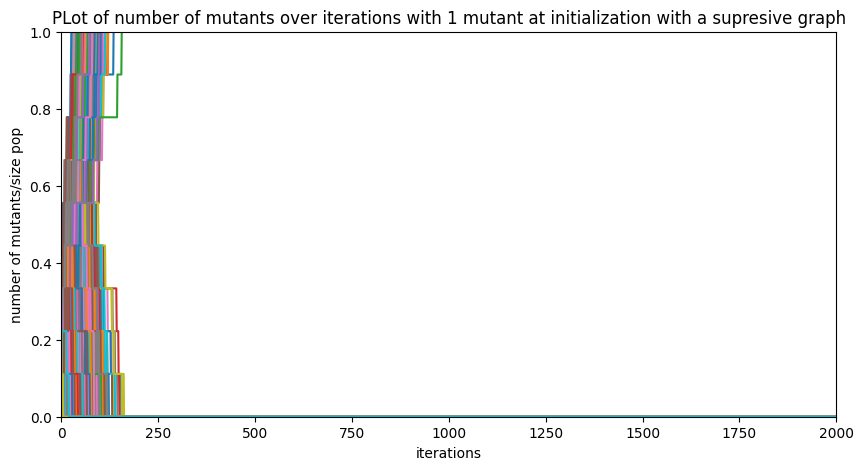

In [ ]:
# plot the number of mutants over iterations for each simulation with suppressive graph "f"
import matplotlib.pyplot as plt
for t in l_results:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants/size pop')
plt.ylim(0, 1)
plt.xlim(0, nb_iterations)
plt.gcf().set_size_inches(10, 5)
plt.title('PLot of number of mutants over iterations with 1 mutant at initialization with a supresive graph')

print("Fixation probability with suppresive graph 'f': ", cptFix/nbrRun)

In [ ]:
# Simulation of the Moran process with a single mutant at the start
# We run 1000 simulations with a suppresor graph of 20 nodes "g"
# And we change the population size from 1 to 20
# We record the fixation probability for each population size
from random import randint

nb_iterations = 1000
delay_between_displayed_frames = 50  # in ms
nbrRun = 1000
fixation_probabilities_G = []
fixation_probabilities_F = []

# Loop over different population sizes
for nb_nodes in range(1, 21):
    cptFix1 = 0
    l_results = []
    # Loop over the number of runs
    for test in range(0, nbrRun):
        types_G = np.zeros(nb_nodes, dtype=np.int32)
        types_G[randint(0, nb_nodes - 1)] = 1  # Fix the range to be within bounds
        history_G = run_task(nb_nodes, [(i - 1, i) for i in range(1, nb_nodes)], nb_iterations, types_G, delay_between_displayed_frames, direct=True)
        types_F = np.zeros(nb_nodes, dtype=np.int32)
        types_F[randint(0, nb_nodes - 1)] = 1
        history_F = run_task(nb_nodes, [(0, i) for i in range(1, nb_nodes)], nb_iterations, types_F, delay_between_displayed_frames, direct=True)
        fixation = False
        # Iteration per Run
        for array in history_G:
            nb_mut = np.count_nonzero(array == 1) / nb_nodes
            if nb_mut == 1 and not fixation:
                fixation = True
                cptFix1 += 1
                break

    fixation_probabilities_G.append(cptFix1 / nbrRun)
    fixation_probabilities_F.append(cptFix1 / nbrRun)

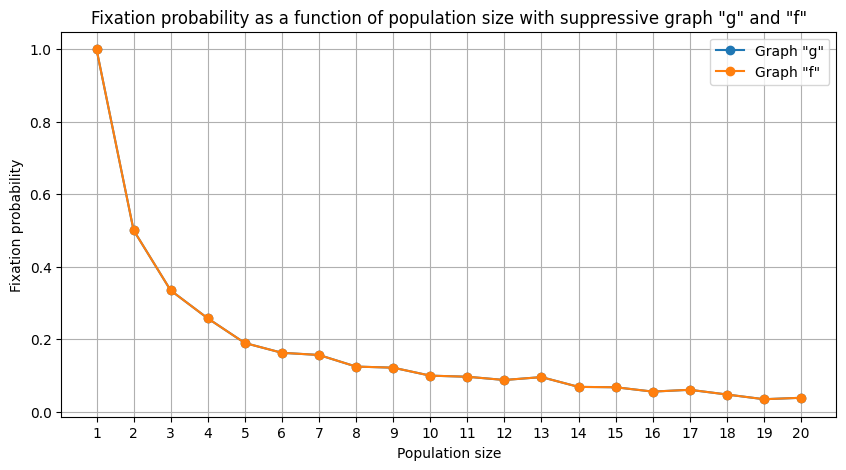

In [ ]:
# Plot the fixation probability as a function of population size with suppressive graph "g"
# and suppressive graph "f"
plt.plot(range(1, 21), fixation_probabilities_G, marker='o', label='Graph "g"')
plt.plot(range(1, 21), fixation_probabilities_F, marker='o', label='Graph "f"')
plt.gcf().set_size_inches(10, 5)
plt.legend()
plt.xlabel('Population size')
plt.ylabel('Fixation probability')
plt.title('Fixation probability as a function of population size with suppressive graph "g" and "f"')
plt.grid(True)
plt.xticks(range(1, 21, 1))
plt.show()

Starting now we increase the number of iterations so that every runs lead to an absorbing state (i.e. all nodes are similar)
**Experimental confirmation of the probability of fixation**

The probability of fixation of the suppressor is given by:

$$
p = \frac{1}{N}
$$

This is independent of \(r\) (fitness).

### For the 'f' graph

The theoretical probability of fixation is:

$$
p(1)_{\text{theoretical}} = \frac{1}{N} = \frac{1}{9} \approx 0.11
$$

Over 1000 runs, we observe that:

$$
p(1)_{\text{obs}} = 0.115
$$

This is approximately 0.11, confirming the formula for calculating the probability of fixation.

### For the 'g' graph with \(N = 5\)

The theoretical probability of fixation is:

$$
p(1)_{\text{theoretical}} = \frac{1}{N} = \frac{1}{5} = 0.2
$$

According to the graph, over 1000 runs, we observe that:

$$
p(1)_{\text{obs}} = 0.190
$$

This is approximately 0.2, confirming the formula once again.

### Sensitivity to the number of nodes:

As indicated by the formula for the suppressor graph, we observe that as the number of nodes increases, the probability of fixation decreases independently of the structure of the graph ('f' or 'g'), as shown in the graph above.


---
---
---

# <font color='orange'>PART 3: amplifier of selection</font>

Study the amplifier graph "(a)" seen in the lecture's slides, starting with one mutant. Confirm experimentally the probability of fixation. Show a figure with multiple runs (X-axis: iterations, Y-axis: number of mutants / population size).

Propose of an original amplifier graph, not seen in the lecture.

In [ ]:
# Moran process with an amplifier graph
# We run 10000 simulations with an amplifier graph of 9 nodes "A"
# We record the evolution of the number of mutants at each iteration
# We count the number of fixation events to calculate the fixation probability
nb_iterations = 5000
delay_between_displayed_frames = 50  # in ms
l_results = []
cptFix = 0
nbrRun = 10000
nb_nodesAmplifier = 9

for run in range(nbrRun):
    types_A = np.zeros(nb_nodesAmplifier, dtype=np.int32)
    types_A[randint(0, nb_nodesAmplifier - 1)] = 1  # Fix the range to be within bounds
    l_edges_A = [(0, i) for i in range(1, 9)] # amplifier graph (undirected)
    history_A = run_task(nb_nodesAmplifier, l_edges_A, nb_iterations, types_A, delay_between_displayed_frames, False)
    x_A = []
    fixation = False
    for array in history_A:
        nb_mut = np.count_nonzero(array == 1) / nb_nodesAmplifier
        if nb_mut == 1 and not fixation:
            fixation = True
            cptFix += 1
        x_A.append(nb_mut)
    l_results.append(x_A)

print("Fixation probability with amplifier graph: ", cptFix / nbrRun)

Fixation probability with amplifier graph:  0.1899


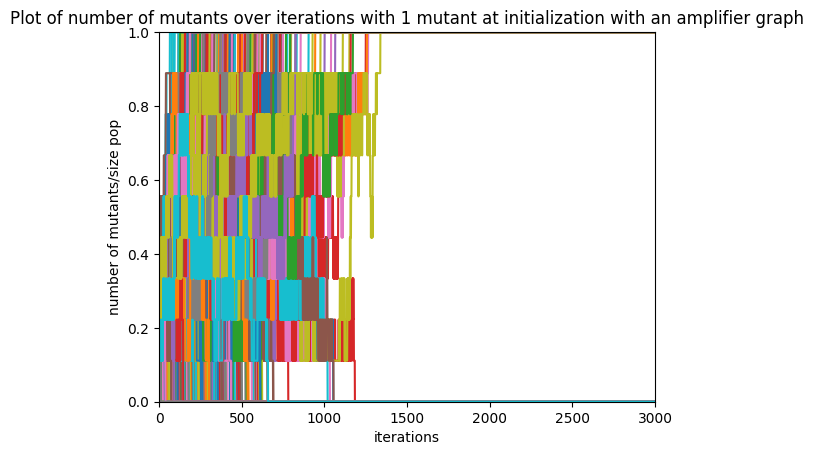

In [ ]:
# plot the number of mutants over iterations for each simulation with amplifier graph "A"
import matplotlib.pyplot as plt
for t in l_results:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants/size pop')
plt.ylim(0, 1)
plt.xlim(0, nb_iterations)
plt.title('Plot of number of mutants over iterations with 1 mutant at initialization with an amplifier graph')
plt.show()

Amplifier graph
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 6), (5, 7), (5, 8), (6, 5), (7, 5), (8, 5)]


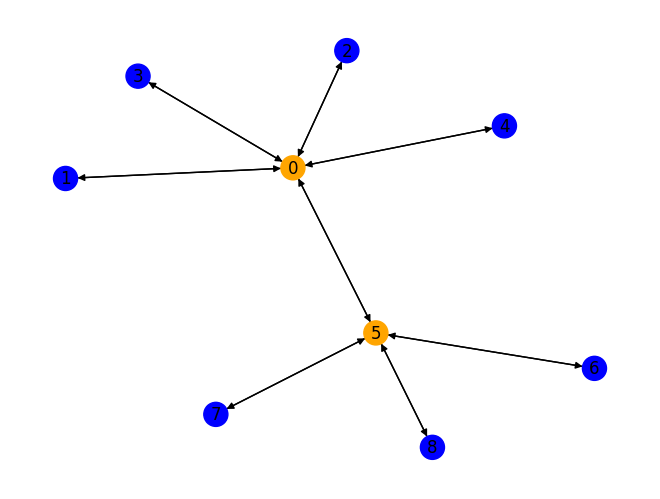

In [ ]:
# Create our amplifier graph
gAmplif = nx.DiGraph()
gAmplif.add_nodes_from(range(9))
gAmplif.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (0,3), (3, 0), (0, 4), (4, 0), (5, 0), (0, 5), (5, 6), (6,5), (5, 7), (7, 5), (5, 8), (8, 5)])
print("Amplifier graph")
print(gAmplif.edges())
node_colors = ['orange' if gAmplif.degree(node) > 2 else 'blue' for node in gAmplif.nodes()]
nx.draw(gAmplif, with_labels=True, node_color=node_colors)

In [ ]:
# Simulation of the Moran process with a single mutant at the start
# We run 10000 simulations with this new amplifier declared before
# We record the evolution of the number of mutants at each iteration
# We count the number of fixation events to calculate the fixation probability
nb_iterations = 5000
delay_between_displayed_frames = 50  # in ms
l_results = []
cptFix = 0
nbrRun = 10000
nb_nodesAmplifier = 9

for run in range(nbrRun):
    types_F = np.zeros(9, dtype=np.int32)
    types_F[randint(0, 8)] = 1  # Fix the range to be within bounds
    l_edges = [(0, 1), (1, 0), (0, 2), (2, 0), (0,3), (3, 0), (0, 4), (4, 0), (5, 0), (0, 5), (5, 6), (6, 5), (5, 7), (7, 5), (5, 8), (8, 5)]
    history_F = run_task(nb_nodesAmplifier, l_edges, nb_iterations, types_F, delay_between_displayed_frames, direct=False)
    x_F = []
    fixation = False
    for array in history_F:
        nb_mut = np.count_nonzero(array == 1) / nb_nodesAmplifier
        if nb_mut == 1 and not fixation:
            fixation = True
            cptFix += 1
        x_F.append(nb_mut)
    l_results.append(x_F)

print("Fixation probability with amplifier graph: ", cptFix / nbrRun)

Fixation probability with amplifier graph:  0.1763


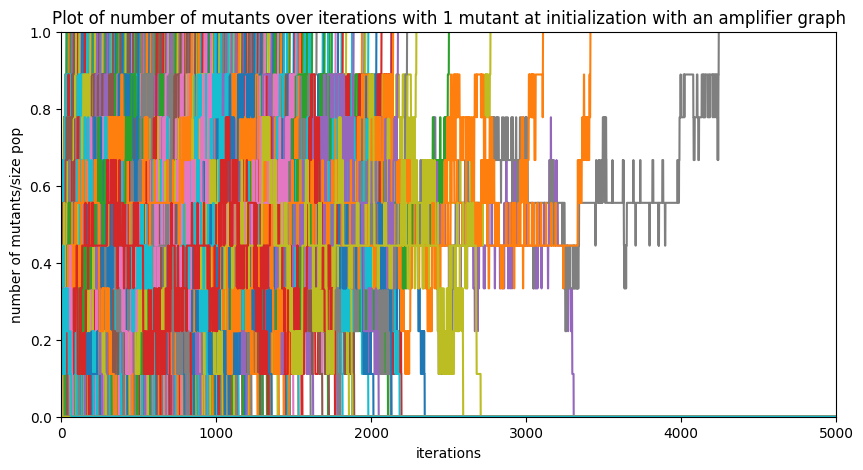

In [ ]:
# plot the number of mutants over iterations for each simulation with the new amplifier graph
import matplotlib.pyplot as plt
for t in l_results:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants/size pop')
plt.gcf().set_size_inches(10, 5)
plt.ylim(0, 1)
plt.xlim(0, nb_iterations)
plt.title('Plot of number of mutants over iterations with 1 mutant at initialization with an amplifier graph')
plt.show()

**Estimation of the theoretical fixation probability:**

For the amplifier graph 'A', the parameters are defined as follows:

- $r(\text{mutant}) = \frac{\text{mutant fitness}}{\text{resident fitness}} = \frac{1.1}{1} = 1.1$
- The population size is set to $N = 9$

### 1) Theoretical calculation of the fixation probability

According to the slides, the amplification of the graph is \( r^2 \). The theoretical fixation probability of the mutant is calculated as follows:

$$
p(2)_{\text{theoretical}} = \frac{1 - \frac{1}{r^2}}{1 - \frac{1}{r^{2N}}} = \frac{1 - \frac{1}{1.1^2}}{1 - \frac{1}{1.1^{2 \times 9}}} \approx 0.21
$$

### 2) Observed fixation probability

With 10000 runs and 5000 iterations, we observe $p_{\text{obs}} = 0.1899$, which is close to the theoretical value of 0.21, but slightly lower. This difference can be explained by the stochastic nature of the process. We tried to increased the number of runs and iterations to get a more accurate result, it did not change much.


### 3) Proposed amplifier graph

We propose a structured amplifier graph with the following relationships:

\[
[(0, 1), (1, 0), (0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (5, 0), (0, 5), (5, 6), (6, 5), (5, 7), (7, 5), (5, 8), (8, 5)]
\]

The experimentally observed fixation probability from 10000 runs, 3000 iterations per run, and one initial mutant is p = 0.1771.

---
---
---

# <font color='orange'>PART 4: non-standard topology</font>

Study the code. Explore experimentally the probability of fixation of a single mutant. Provide an estimate of fixation time.

Explore the sensitivity to population size (try 50 and 100, each time with two dense clusters and one single link inbetween).

In [ ]:
nb_iterations = 200000
delay_between_displayed_frames = 50  # in ms
from random import randint

print("Standard graph")
cpt_Fix = 0
history = None  # Reset the history variable
nbr_run = 1000
l_fix_time = []
ltest_Iter = []
l_proba_res = []
for nb_nodes in range(10, 110, 10):
    l_fix_time_sub = []
    cpt_Fix = 0
    for run in range(0, nbr_run):
        edges1 = [(i, i + 1) for i in range(0, nb_nodes - 1)] + [(nb_nodes - 1, int(nb_nodes/2))]
        edges1.remove((int(nb_nodes/2) - 1, int(nb_nodes/2)))
        edges1.append((int(nb_nodes/2) - 1, 0))
        edges1.append((0, int(nb_nodes/2)))
        types_Standard = np.zeros(nb_nodes, dtype=np.int32)
        types_Standard[randint(0, nb_nodes - 1)] = 1
        history = run_task(nb_nodes, edges1, nb_iterations, types_Standard, delay_between_displayed_frames)
        for i in range(0, len(history) - 1):
            array = history[i]
            if np.count_nonzero(array == 1) == nb_nodes:
                cpt_Fix += 1
                l_fix_time_sub.append(i)
                break
        if nb_nodes == 100:
            cpt_mut = np.count_nonzero(history[-1])
            if cpt_mut != 0 and cpt_mut != 100:
                ltest_Iter.append((cpt_mut))
    l_fix_time.append((int(sum(l_fix_time_sub) / max(len(l_fix_time_sub), 1)), nb_nodes))
    l_proba_res.append(((cpt_Fix / nbr_run), nb_nodes))

In [ ]:
print('l_fix_time: ', l_fix_time)
print('ltest_Iter: ', ltest_Iter)
print('l_proba_res: ', l_proba_res)

l_fix_time:  [(228, 10), (1305, 20), (3547, 30), (7458, 40), (12967, 50), (19877, 60), (29101, 70), (42622, 80), (53454, 90), (66240, 100)]
ltest_Iter:  []
l_proba_res:  [(0.132, 10), (0.103, 20), (0.094, 30), (0.094, 40), (0.09, 50), (0.103, 60), (0.083, 70), (0.109, 80), (0.086, 90), (0.09, 100)]


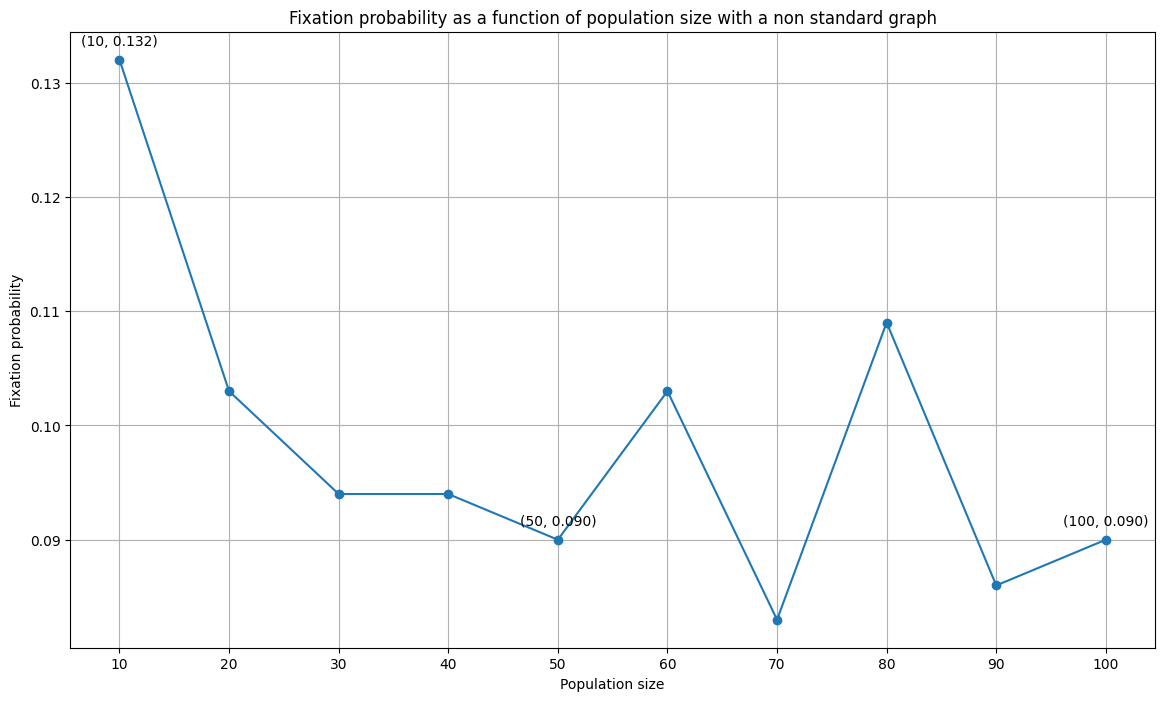

In [ ]:
# Plot the fixation probability as a function of population size with a non-standard graph
plt.plot([x[1] for x in l_proba_res], [x[0] for x in l_proba_res], marker='o')
plt.xlabel('Population size')
plt.ylabel('Fixation probability')
plt.xticks(range(10, 110, 10))
plt.gcf().set_size_inches(14, 8)
# Affiche les coordonnées des points d'abcisses 10, 50 et 100
for y, x in l_proba_res:
    if x in [10, 50, 100]:
        plt.annotate(f'({x}, {y:.3f})', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Fixation probability as a function of population size with a non standard graph')
plt.grid(True)
plt.show()

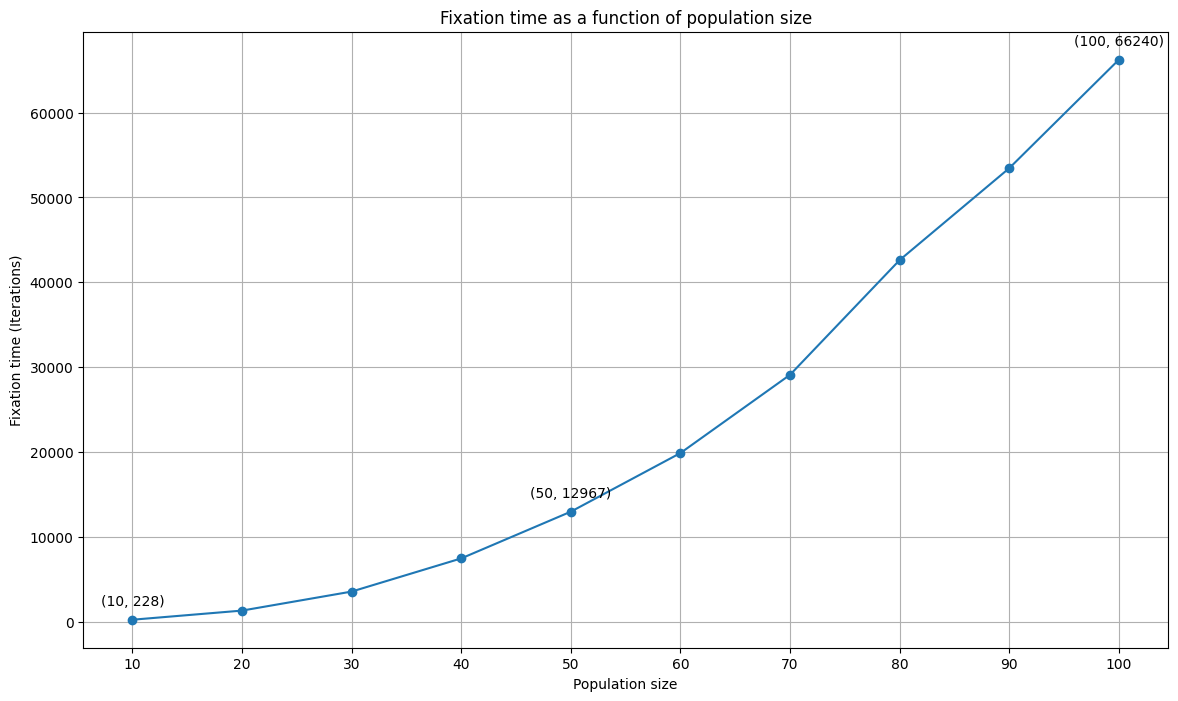

In [ ]:
# Plot the fixation time as a function of population size
plt.plot([x[1] for x in l_fix_time], [x[0] for x in l_fix_time], marker='o')
plt.xlabel('Population size')
plt.ylabel('Fixation time (Iterations)')
plt.xticks(range(10, 110, 10))
plt.gcf().set_size_inches(14, 8)
# Display the coordinates of points with population sizes 10, 50, and 100
for y, x in l_fix_time:
    if x in [10, 50, 100]:
        plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Fixation time as a function of population size')
plt.grid(True)
plt.show()

This graph is a system with two circles connected by one point of each circle.
### 1) Initial Code: 5 mutants in the initial condition and N = 10

*(This code isn't in the notebook anymore but still available on the original source)*
With the initial code: 5 mutants on one closed side and 5 residents on the other in the initial condition, there is, over 100 trials, a fixation probability of 1. We can therefore hypothesize that this is a critical state of the system from which the fixation probability is 1.

### 2) One mutant in the initial condition and N = 10

To experimentally estimate the fixation probability of a single mutant, we conducted 5000 trials with 1000 iterations each.
We observe a fixation probability of a mutant in the initial condition is P(fixation) = N(fixation of mutants) / N(trials) = 0.113.

We also calculate the fixation time, which is the number of iterations required for the mutant to fixate in the population. The fixation time is calculated as the average number of iterations required for the mutant to fixate in the population. The fixation time is around 228 iterations for N = 10.

### 3) Effect of population: one mutant in the initial condition and N = 50 / N = 100

With one mutant in the initialization, 1000 trials, and 200000 iterations: we observe that for a population size N1 = 10, the fixation probability p1 = 0.132, for a population size N2 = 50, the fixation probability is 0.090 and for a population size N3 = 100, the fixation probability is 0.090.

The fixation time for \(N = 50\) is around 12,967 iterations and for \(N = 100\) is around 66,240 iterations. In the case of \(N = 100\), we verified that there was no population still evolving after 150,000 iterations.

We observe from the graph "fixation probability as a function of population size" that with a fixed number of 1 mutant in the initial state, there is a decreasing fixation probability as the population size increases but it seems to stabilize around 0.09 from N = 50. But as we can see the trend is not clear from N = 50 to N = 100, to fix this we need to increase the number of trials but our computational resources are limited.

---
---
---

# <font color='orange'>PART 5: characterizing topologies</font>

Consider two topologies:
1. ring: each node is connected to two neighbourgs, forming a closed loop.
2. line: similar to a ring, but with one single missing link.

Explore both topologies (population size of N, one mutant). What can you say about fixation probabilities?

In [ ]:
# Simulation of the Moran process with ring graph
# We run 200 simulation per nb_nodes from 1 to 50
# We record the evolution of the number of mutants at each iteration
# We count the number of fixation events to calculate the fixation probability
# We record the fixation time for each simulation
from random import randint
nb_iterations = 10000
delay_between_displayed_frames = 50  # in ms

l_results = []
l_not_fixed_ring = []
l_fix_time_ring = []
nbRunRing = 200
max_nodes = 50
for nb_nodesring in range(1, max_nodes + 1):
    cpt_not_fixed = 0
    l_fix_time_sub = []
    edges_ring = [(i, (i + 1) % nb_nodesring) for i in range(nb_nodesring)]
    for i in range(0, nbRunRing):
        types = [0] * nb_nodesring
        types[randint(0, nb_nodesring - 1)] = 1
        types = np.array(types, dtype=np.int32)
        history_ring = run_task(nb_nodesring, edges_ring, nb_iterations, types, delay_between_displayed_frames, direct=False)
        x_F = []
        added = False
        for index, array in enumerate(history_ring):
            ratio_mut = np.count_nonzero(array == 1) / nb_nodesring
            x_F.append(ratio_mut)
            if ratio_mut == 1 and not added:
                l_fix_time_sub.append(index)
                added = True
        if not added:
            cpt_not_fixed += 1
        l_results.append(x_F)
    l_fix_time_ring.append((int(sum(l_fix_time_sub) / max(len(l_fix_time_sub), 1)), nb_nodesring))
    cpt_not_fixed = cpt_not_fixed / nbRunRing
    l_not_fixed_ring.append(cpt_not_fixed)
print(l_fix_time_ring)

[(0, 1), (1, 2), (3, 3), (8, 4), (18, 5), (34, 6), (52, 7), (75, 8), (112, 9), (164, 10), (257, 11), (339, 12), (299, 13), (417, 14), (487, 15), (709, 16), (701, 17), (896, 18), (1001, 19), (1846, 20), (1375, 21), (1683, 22), (1672, 23), (2434, 24), (2213, 25), (2552, 26), (2552, 27), (3398, 28), (4161, 29), (3799, 30), (4204, 31), (4472, 32), (3510, 33), (4725, 34), (4468, 35), (5270, 36), (3947, 37), (6533, 38), (6103, 39), (5774, 40), (6928, 41), (5801, 42), (6205, 43), (6578, 44), (6965, 45), (7583, 46), (7091, 47), (7495, 48), (8167, 49), (6499, 50)]


In [ ]:
# Simulation of the Moran process with line graph
# We run 200 simulation per nb_nodes from 1 to 50
# We record the evolution of the number of mutants at each iteration
# We count the number of fixation events to calculate the fixation probability
# We record the fixation time for each simulation

from random import randint

nb_iterations = 10000
delay_between_displayed_frames = 50  # in ms
l_results = []
l_fix_time_line = []
l_not_fixed_line = []
nbRunLine = 200
max_nodes = 50
for nb_nodesline in range(1, max_nodes + 1):
    cpt_not_fixed = 0
    l_fix_time_sub = []
    edges_line = [(i, (i + 1)) for i in range(nb_nodesline - 1)]
    for i in range(0, nbRunLine):
        types = [0] * nb_nodesline
        types[randint(0, nb_nodesline - 1)] = 1
        types = np.array(types, dtype=np.int32)
        history_ring = run_task(nb_nodesline, edges_line, nb_iterations, types, delay_between_displayed_frames, direct=False)
        x_F = []
        added = False
        for index, array in enumerate(history_ring):
            ratio_mut = np.count_nonzero(array == 1) / nb_nodesline
            x_F.append(ratio_mut)
            if ratio_mut == 1 and not added:
                l_fix_time_sub.append(index)
                added = True
        if not added:
            cpt_not_fixed += 1
        l_results.append(x_F)
    l_fix_time_line.append((int(sum(l_fix_time_sub) / max(len(l_fix_time_sub), 1)), nb_nodesline))
    cpt_not_fixed = cpt_not_fixed / nbRunLine
    l_not_fixed_line.append(cpt_not_fixed)
print(l_fix_time_line)

[(0, 1), (1, 2), (6, 3), (23, 4), (44, 5), (79, 6), (127, 7), (187, 8), (244, 9), (393, 10), (425, 11), (517, 12), (926, 13), (807, 14), (893, 15), (1112, 16), (1565, 17), (2128, 18), (2308, 19), (2836, 20), (2212, 21), (3717, 22), (2769, 23), (3521, 24), (3863, 25), (4364, 26), (5179, 27), (4474, 28), (5305, 29), (6747, 30), (5263, 31), (5841, 32), (5865, 33), (6300, 34), (5359, 35), (5819, 36), (6518, 37), (6467, 38), (7339, 39), (6832, 40), (6368, 41), (6674, 42), (7796, 43), (7102, 44), (7138, 45), (7876, 46), (7163, 47), (8829, 48), (8949, 49), (9318, 50)]


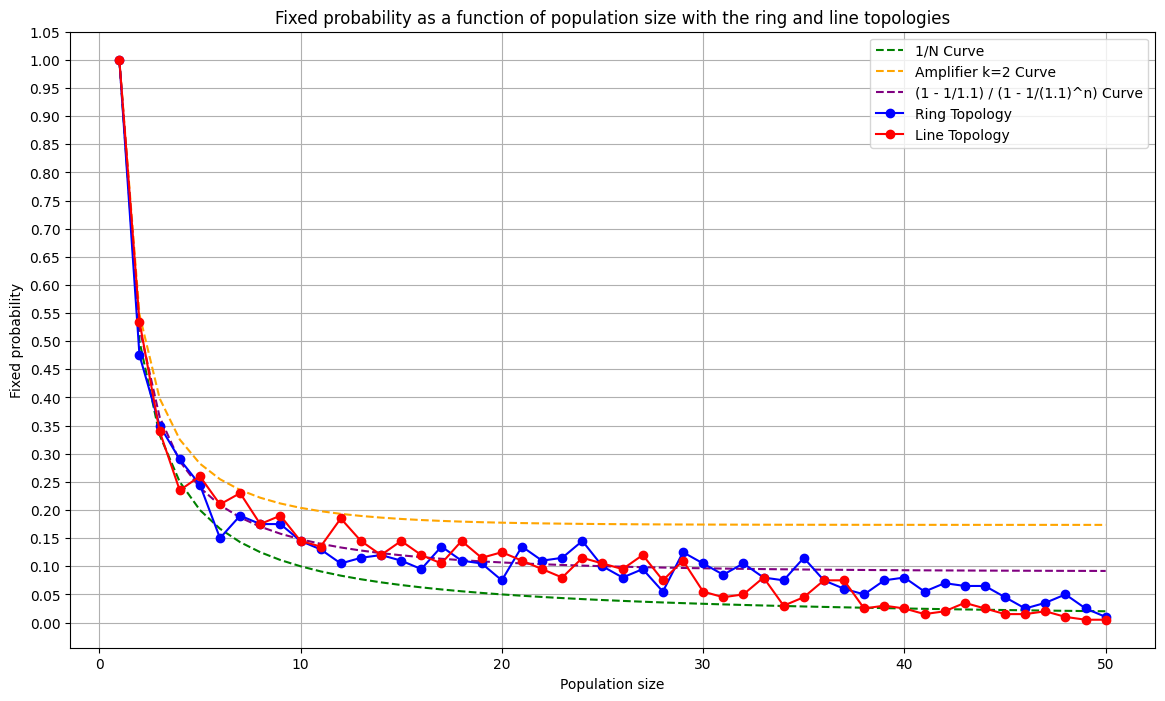

In [ ]:
# Plot the fixation probability as a function of population size with the ring and line topologies
import matplotlib.pyplot as plt
avg = 0
max_diff = 0
for i in range(0, len(l_not_fixed_ring)):
    l_not_fixed_line[i] = 1 - l_not_fixed_line[i]
    l_not_fixed_ring[i] = 1 - l_not_fixed_ring[i]

# Plot the 1/N curve
N_values = np.arange(1, 51)
one_over_N = 1 / N_values
plt.plot(N_values, one_over_N, linestyle='--', color='green', label='1/N Curve')

# Plot the amplifier curve (1 - 1/1.1^2) / (1 - 1/(1.1)^2n)
amplifier_curve = (1 - 1 / 1.1 ** 2) / (1 - 1 / 1.1 ** (2 * N_values))
plt.plot(N_values, amplifier_curve, linestyle='--', color='orange', label='Amplifier k=2 Curve')

# Plot the (1- 1/1,1) / 1- 1/(1,1)^n curve
one_minus_one_over_N = (1 - 1 / 1.1) / (1 - 1 / 1.1 ** N_values)
plt.plot(N_values, one_minus_one_over_N, linestyle='--', color='purple', label='(1 - 1/1.1) / (1 - 1/(1.1)^n) Curve')

# Plot the non-fixed values for the ring topology
plt.plot(range(1, 51),  l_not_fixed_ring, marker='o', color='blue', label='Ring Topology')

# Plot the non-fixed values for the line topology
plt.plot(range(1, 51), l_not_fixed_line, marker='o', color='red', label='Line Topology')

# Add labels and title
plt.xlabel('Population size')
plt.ylabel('Fixed probability')
plt.title('Fixed probability as a function of population size with the ring and line topologies')

plt.yticks(np.arange(0, 1.1, 0.05))
# Add legend
plt.legend()

# Set the size of the figure
plt.gcf().set_size_inches(14, 8)

# Show the plot
plt.grid(True)
plt.show()

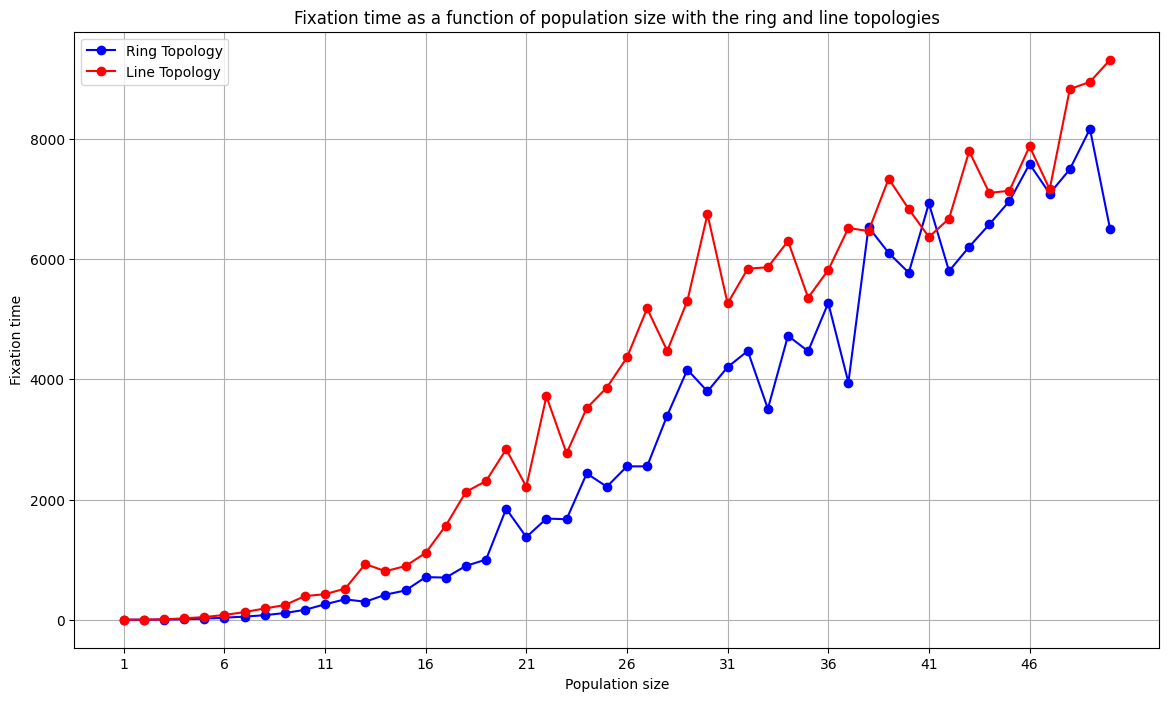

In [ ]:
# Plot the fixation time as a function of population size with the ring and line topologies
import matplotlib.pyplot as plt
plt.plot([x[1] for x in l_fix_time_ring], [x[0] for x in l_fix_time_ring], marker='o', color='blue', label='Ring Topology')
plt.plot([x[1] for x in l_fix_time_line], [x[0] for x in l_fix_time_line], marker='o', color='red', label='Line Topology')
plt.xlabel('Population size')
plt.ylabel('Fixation time')
plt.xticks(range(1, 51, 5))
plt.legend()
plt.gcf().set_size_inches(14, 8)
plt.title('Fixation time as a function of population size with the ring and line topologies')
plt.grid(True)
plt.show()


We observe in both cases that the probability of fixation decreases as the population size increases. This decrease appears to follow the curve of the function of fixation in isothermal graph :

$$
\frac{1 - \frac{1}{r}}{1 - \frac{1}{r^N}}
$$

Where \( r \) is the fitness ratio between the mutant and the resident. This trend is observed for both topologies. The deviation from the isothermal curve might be due to the an insufficient number of iterations wich cause a reduction in fixation probability in large graphs (approximately for \( n > 35 \)).

Moreover, both topologies are above the curve \( 1/N \), indicating that they do not behave like suppressors of selection graphs. While the mutant's fitness ratio has some influence, population size remains a key factor.

Similarly to the the part 4, the fixation time (i.e number of iterations needed) increases as the number of nodes increases in a rather similation way for both topologies. Althougt, visually it seems that the fixation time is faster for the ring topology.

While ring graph is structurally an isothermal graph, the line graph seems to behave almost like an isothermal graph because it's probability of fixation in function of the population size appears similar to the ring graph but the time it takes to fixate seems to be higher on average.